In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
%matplotlib inline
plt.style.use("seaborn")
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
data = pd.read_csv("./datasets/Metro_time_series.csv")

In [4]:
cols = ['Date', 'RegionName', 'ZHVI_AllHomes']
data = data[data['ZHVI_AllHomes'] > 0]
data = data.filter(cols)
data = data.rename(columns={"RegionName": "CBSA_Code"})
cityList = np.unique(data['CBSA_Code'])
metro = []
for code in tqdm(cityList):
    metro.append(data[data['CBSA_Code']  == str(code)])


100%|██████████| 730/730 [00:09<00:00, 77.85it/s]


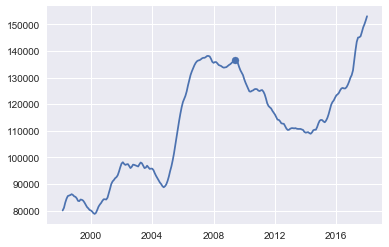

In [5]:
city1 = metro[0]
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(city1['Date']).dt.date, city1['ZHVI_AllHomes'])
ax.scatter(pd.to_datetime('2009-05-31'), city1[city1['Date'] == '2009-05-31']['ZHVI_AllHomes'])

In [6]:
def movingAverage_normalize(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    moving_avg = ret[n - 1:] / n
    return np.array([(x-np.mean(moving_avg))/np.std(moving_avg) for x in moving_avg])
#fig, ax = plt.subplots()
#ax.scatter(pd.to_datetime(city1['Date'][4:]).dt.date, movingAverage_normalize(city1['ZHVI_AllHomes'].values))
#plt.show()
movingAverage_normalize(city1['ZHVI_AllHomes'].values)
# don't send moving average 
#  CHECK IF AFFECTS MOVING AVERAGE AFFECTS ARIMA

array([-1.52245317, -1.46376916, -1.41346858, -1.37993486, -1.36526386,
       -1.36631179, -1.37155143, -1.38517451, -1.41137273, -1.43547509,
       -1.44805023, -1.45957745, -1.46796088, -1.47424845, -1.48891945,
       -1.51826146, -1.55179518, -1.58847268, -1.61991055, -1.64610876,
       -1.67021113, -1.69221763, -1.70374485, -1.70164899, -1.68278627,
       -1.64925255, -1.60628747, -1.55913068, -1.51721353, -1.48787152,
       -1.46796088, -1.4470023 , -1.41870823, -1.37783901, -1.31810707,
       -1.24684791, -1.17768462, -1.11690475, -1.07079589, -1.03621424,
       -0.99744087, -0.94714029, -0.88950421, -0.8308202 , -0.78575927,
       -0.75956105, -0.74803383, -0.75012969, -0.76480069, -0.78156755,
       -0.78890305, -0.78995098, -0.79309477, -0.79099891, -0.78261548,
       -0.78156755, -0.78051962, -0.77108826, -0.76270484, -0.76165691,
       -0.76794448, -0.78051962, -0.79309477, -0.8088137 , -0.82138884,
       -0.8234847 , -0.82767642, -0.84549121, -0.86854564, -0.89

In [7]:
def find_start(city):
    """
    returns recession start date, measured as the largest local maximum ZHVI for a given city
    takes: city (pd.dataframe) [Date, ZHVI_avg_norm]
    returns: start_date (pd.datetime)
    """
    city = city[city['Date'] < "2012"]
    d = lambda i: city['ZHVI_AllHomes'].iloc[i] - city['ZHVI_AllHomes'].iloc[i-1]
    diffs = np.array([d(i) for i in range(1, len(city))])
    # reshape dataframe to include diffs
    city = city.iloc[1:]
    city['Diffs'] = diffs
    # find local maxes using diffs
    is_max = np.array([(city['Diffs'].iloc[i] >= 0) and (city['Diffs'].iloc[i+1] <= 0) for i in range(len(city) - 1)])
    is_max = np.append(is_max, False)

    # check for presence of local maxes at all
    if np.count_nonzero(is_max) == 0:
        return 0
    # add 'is_maximum' truth column to dataframe
    city['Max'] = is_max
    # filter and find largest max
    theMax = city[city['Max'] == 1.0].sort_values("ZHVI_AllHomes", ascending=False).iloc[0]
    start_date = theMax['Date']
    return start_date

In [8]:
def find_end(city, ARIMA_50):
    """
    returns recession end date, measured as the first point of intersection between ZHVI and ARIMA_50 for a given city
    takes: city (pd.dataframe) [Date, ZHVI_avg_norm], ARIMA_50 (pd.dataframe) [Date, forecasted_ZHVI_norm] 
    returns: end_date (pd.datetime)
    """
    # calculate diffs
    diffs = np.array([ARIMA_50['forecasted_ZHVI_norm'].iloc[i] - city['ZHVI_avg_norm'].iloc[i] for i in range(len(city))])
    city_resid = pd.DataFrame(data={'Date': city['Date'].values, 'Delta': diffs})
    # filter only positive residuals, and most recent one is the last recession date
    most_recent_positive_delta = city_resid[city_resid['Delta'] > 0].sort_values("Date", ascending=False).iloc[0]
    end_date = most_recent_positive_delta['Date']
    return end_date

In [9]:
def calc_resid(city, predicted, max, end):
    """
    Params:
    city -- time-series dataframe object containing Date and ZHVI columns
    predicted -- predicted values from max to last date of city time-series
    max -- datetime object from index of city representing peak ZHVI
    end -- datetime object from index of city representing intersection of 
    actual and predicted ZHVI or last date of actual
    """
    actual = city[city['Date'] > max and city['Date'] < end]['ZHVI']
    predicted_np = predicted[:actual.size]
    actual_np = actual.to_numpy(dtype=np.float)
    
    return np.subtract(predicted, actual_np)

In [27]:
def ARIMA_50(city, start, params=(5,1,1)):
    """
    Params:
    city -- time-series dataframe object containing Date and ZHVI columns
    start -- datetime object from index of city representing peak ZHVI
    params -- p, d, and q parameters for ARIMA
    """
    
    #add start.dt.strftime('%Y-%m-%d') to convert datetime to string
    
    from statsmodels.tsa.arima_model import ARIMA
    
    before = city[['Date', 'ZHVI_AllHomes']][city['Date'] < start].set_index(['Date'])['ZHVI_AllHomes']
    model = ARIMA(endog=np.array(before, dtype=np.float), order=(5, 1, 1))
    model_fit = model.fit(disp=0)    
    return model_fit.predict(before.shape[0], city1.shape[0])


In [28]:
def find_AUB(metro):
    start = find_start(metro)
    arima = ARIMA_50(metro, start)
    
    end = find_end(start, arima)
    return calc_resid(metro, arima, start, end)

In [29]:
# RANDOM STUFF DELETE LATER

from statsmodels.tsa.arima_model import ARIMA
city1.tail()
before = city1[['Date', 'ZHVI_AllHomes']][city1['Date'] < '2017-08-31'].set_index(['Date'])['ZHVI_AllHomes']
model = ARIMA(endog=np.array(before, dtype=np.float), order=(5, 1, 1))
model_fit = model.fit(disp=0)
#np.array(before, dtype=np.float)[0]
#city1['dt'] = city1
#np.array(city1['Date'], dtype='datetime64')
model_fit.predict(before.shape[0], city1.shape[0])
find_AUB(city1)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [73]:
city1 = city1[city1['Date'] < "2012"]
d = lambda i: city1['ZHVI_AllHomes'].iloc[i] - city1['ZHVI_AllHomes'].iloc[i-1]
diffs = np.array([d(i) for i in range(1, len(city1))])
# reshape dataframe to include diffs
city1 = city1.iloc[1:]
city1['Diffs'] = diffs
city1['Diffs']
# find local maxes using diffs
is_max = np.array([(city1['Diffs'].iloc[i] >= 0) and (city1['Diffs'].iloc[i+1] <= 0) for i in range(len(city1) - 1)])
is_max = np.append(is_max, False)

# check for presence of local maxes at all
if np.count_nonzero(is_max) == 0:
    print(0)
# add 'is_maximum' truth column to dataframe
city1['Max'] = is_max
# filter and find largest max
theMax = city1[city1['Max'] == 1.0].sort_values("ZHVI_AllHomes", ascending=False).iloc[0]
start_date = theMax['Date']
start_date

'2007-07-31'